In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler

### 1) Reading the Data
*NOTE: Specified DATA_PATH should have contain the directories for \train and \train_filtered* <br>
*NOTE2: Choose whether x_train_data_series is filtered or not*

In [2]:
DATA_PATH = 'C:\\Users\\Sean\\Desktop\\AI4E_A3' # Directory containing all the data
FILTERED = False # Whether to use the filtered data

# The dataset is sampled at 500 Hz
DATA_FREQUENCY = 500 
# Simple sorter function to sort the file strings in the correct order (by subj#, series#)
file_name_sorter = lambda string_list: sorted(string_list, key=lambda s: (int(re.search(r'subj(\d+)', s).group(1)), int(re.search(r'series(\d+)', s).group(1)) if re.search(r'series(\d+)', s) else 0))


# Take the first 6 series of each subject to be the training set
train_data_files = file_name_sorter(glob(os.path.join(DATA_PATH,'train', 'subj*_series[1-6]_data.csv')))
train_filtered_data_files = file_name_sorter(glob(os.path.join(DATA_PATH,'train_filtered', 'subj*_series[1-6]_*.csv')))
train_event_files = file_name_sorter(glob(os.path.join(DATA_PATH, 'train', 'subj*_series[1-6]_events.csv')))

# Take the 7th and 8th series to be the test set
test_data_files = file_name_sorter(glob(os.path.join(DATA_PATH, 'train', 'subj*_series[7-8]_data.csv')))
test_filtered_data_files = file_name_sorter(glob(os.path.join(DATA_PATH,'train_filtered', 'subj*_series[7-8]_*.csv')))
test_event_files = file_name_sorter(glob(os.path.join(DATA_PATH, 'train', 'subj*_series[7-8]_events.csv')))



# Remove the first column (id_frame) and convert to NUMPY array, each row is a sample and each column is a feature. Put all of the subj-series into a list

# Train data x, y
y_train_data_series = [pd.read_csv(file, index_col=None, header=0).iloc[:,1:].to_numpy(dtype=np.float16) for file in train_event_files]
if FILTERED:
    x_train_data_series = [pd.read_csv(file, index_col=None, header=0).iloc[:,1:].to_numpy(dtype=np.float16) for file in train_filtered_data_files] # FILTERED EEG signals
else:
    x_train_data_series = [pd.read_csv(file, index_col=None, header=0).iloc[:,1:].to_numpy(dtype=np.float16) for file in train_data_files] # Raw EEG signals

# Test data x, y
y_test_data_series = [pd.read_csv(file, index_col=None, header=0).iloc[:,1:].to_numpy(dtype=np.float16) for file in test_event_files] # labels
if FILTERED:
    x_test_data_series = [pd.read_csv(file, index_col=None, header=0).iloc[:,1:].to_numpy(dtype=np.float16) for file in test_filtered_data_files] # FILTERED EEG signals
else:
    x_test_data_series = [pd.read_csv(file, index_col=None, header=0).iloc[:,1:].to_numpy(dtype=np.float16) for file in test_data_files] # Raw EEG signals

### 2) Scaling the data based on the training signals

In [3]:
scaler = RobustScaler()

scaler = scaler.fit(np.concatenate(x_train_data_series, axis=0))

x_train_data_series = [scaler.transform(series) for series in x_train_data_series]
x_test_data_series = [scaler.transform(series) for series in x_test_data_series]

### 3) Convert the training data into LSTM input format
Takes a specified window size (t_lookback in seconds and sample_reduction) to look back at historical frames in the signal

In [4]:
T_LOOKBACK = 2
SAMPLE_REDUCTION = 50
NON_EVENT_THESHOLD = 0.25 # Proportion of extra non-event (0s) data to put into the training set. Higher the value to put in more non-event data

def generate_input_dataset(x_train_data_series, y_train_data_series, t_lookback=T_LOOKBACK, sample_reduction=SAMPLE_REDUCTION):
    """ Generate the input dataset for the LSTM model. This is done by looking back a fixed amount of time and downsampling the data.
        - t_lookback specifies how many seconds to look back for LSTM
        - sample_reduction specifies how much to downsample the data by (e.g. for 10 means 500/10 = 50 Hz, 50 menans 500/50 = 10 Hz). This mimics a reduced sampling rate of EEG data by taking every nth reading 
    """


    
    n_frames = t_lookback * DATA_FREQUENCY # Number of data frames to look back NOT REDUCED
    x = [] # Train data
    y = [] # Train labels

    # Go through each series/events file separately
    for series_data, series_events in zip(x_train_data_series, y_train_data_series):
        
        for i in range(n_frames-1, series_data.shape[0]-1): # Go through all the possible predictable frames (frames that have hisotrical data avaiable) NOTE: -1 because sometimes the filtered data has 1 more frame
            
            if np.sum(series_events[i]) > 0 or (np.random.random() < NON_EVENT_THESHOLD): # If there is an event at this frame # or randomly sample some of the non-event frames

                x.append(series_data[i-n_frames+sample_reduction:i+sample_reduction:sample_reduction]) # Append the data
                y.append(series_events[i]) # Append the label for the event with the historicla data in mind
                

    return np.array(x), np.array(y)

x_train, y_train = generate_input_dataset(x_train_data_series, y_train_data_series)



### 4) Shuffle the dataset
This step is important otherwise each training sequence is too similar to the previous one

In [5]:
""" SHUFFLE THE DATA """
shuffle_idx = np.random.permutation(x_train.shape[0])
x_train = x_train[shuffle_idx]
y_train = y_train[shuffle_idx]

### 5) Set up the LSTM network

In [6]:
model = tf.keras.models.Sequential(layers=[

    tf.keras.layers.Input((x_train.shape[1], x_train.shape[2]), name='input'), # Input should be frames*features (e.g. 500*32)

    tf.compat.v1.keras.layers.CuDNNLSTM(units=64, name='LSTM'),
    tf.keras.layers.Dropout(0.5, name='dropout'),

    tf.keras.layers.Dense(6, activation='sigmoid', name='dense') # Output layer, 6 independent possible events from 0-1

    ], name='LSTM_model'
)

loss=tf.keras.losses.binary_crossentropy # Binary cross-entropy treats each label prediction as a separate binary classification problem.
optimizer=tf.keras.optimizers.Adam()


model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]) # AUC - minmise false positives, maximise true positives

model.summary()


Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (CuDNNLSTM)            (None, 64)                25088     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 25,478
Trainable params: 25,478
Non-trainable params: 0
_________________________________________________________________


### 6) Train the model

In [7]:
history = model.fit(x_train, y_train, epochs=5, batch_size=1024, validation_split=0.2)

Epoch 1/5
3886/3886 [==============================] - 38s 9ms/step - loss: 0.1761 - accuracy: 0.4829 - precision: 0.5662 - recall: 0.1964 - auc: 0.8849 - val_loss: 0.1357 - val_accuracy: 0.6077 - val_precision: 0.6728 - val_recall: 0.3367 - val_auc: 0.9427
Epoch 2/5
3886/3886 [==============================] - 31s 8ms/step - loss: 0.1334 - accuracy: 0.5854 - precision: 0.6442 - recall: 0.3964 - auc: 0.9455 - val_loss: 0.1168 - val_accuracy: 0.6340 - val_precision: 0.6902 - val_recall: 0.4719 - val_auc: 0.9610
Epoch 3/5
3886/3886 [==============================] - 31s 8ms/step - loss: 0.1219 - accuracy: 0.6115 - precision: 0.6640 - recall: 0.4702 - auc: 0.9565 - val_loss: 0.1094 - val_accuracy: 0.6684 - val_precision: 0.7033 - val_recall: 0.5228 - val_auc: 0.9665
Epoch 4/5
3886/3886 [==============================] - 31s 8ms/step - loss: 0.1154 - accuracy: 0.6231 - precision: 0.6759 - recall: 0.5133 - auc: 0.9617 - val_loss: 0.1070 - val_accuracy: 0.6685 - val_precision: 0.7167 - val_r

### 7) Evaluate the model
Note: https://www.kaggle.com/code/vinaykm/eeg-and-dl tests frames with 1s only


In [8]:
def prediction_test_time_series(x_test_data_series, t_lookback=T_LOOKBACK, sample_reduction=SAMPLE_REDUCTION):
    # Return the time series prediction for a test time series
    n_frames = t_lookback * DATA_FREQUENCY  # Number of data frames to look back 
    
    y_pred = [] # Predictions for each time series to return

    # Go through each of the series files and make predictions for each
    for series_data in x_test_data_series:
        
        # Build the test windows for this series so they can be inferenced by the model
        x_test = []

        for i in range(0, series_data.shape[0]):
            if(i < n_frames-1):
                # For the first n_frames frames, we pad the data with zeros
                x_test.append(np.zeros([n_frames//sample_reduction, series_data.shape[1]]))
            else:
                x_test.append(series_data[i-n_frames+sample_reduction:i+sample_reduction:sample_reduction])

        # Make the predictions for this time series:
        y_pred.append( model.predict(tf.convert_to_tensor(x_test, dtype=tf.float16)) )

        

    return y_pred




y_pred = prediction_test_time_series(x_test_data_series)

# y_test_data_series # Compare y_pred to the GT `y_test_data_series`



4834/4834 [==============================] - 8s 2ms/step


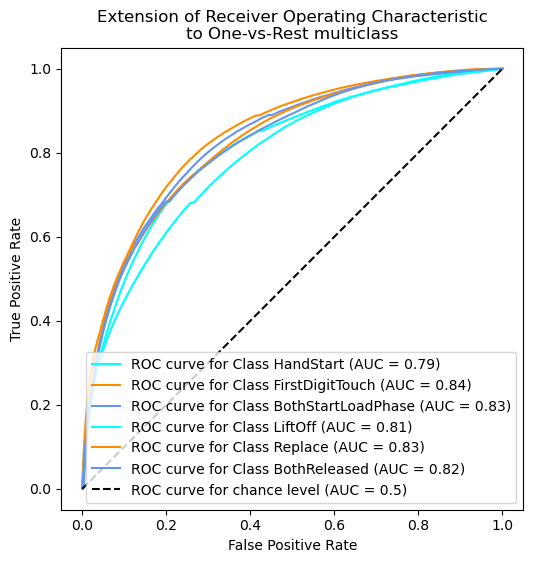

In [9]:
from sklearn.metrics import roc_auc_score
from itertools import cycle
from sklearn.metrics import RocCurveDisplay





y_score = np.concatenate(y_pred, axis=0) # predictions
y = np.concatenate(y_test_data_series, axis=0) # true labels

# roc_auc_score(y, y_score, average=None)


fig, ax = plt.subplots(figsize=(6, 6))
n_classes = 6

class_names = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased'] # TODO check these are the right ones
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color, class_name in zip(range(n_classes), colors, class_names):
    RocCurveDisplay.from_predictions(
        y[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for Class {class_name}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()


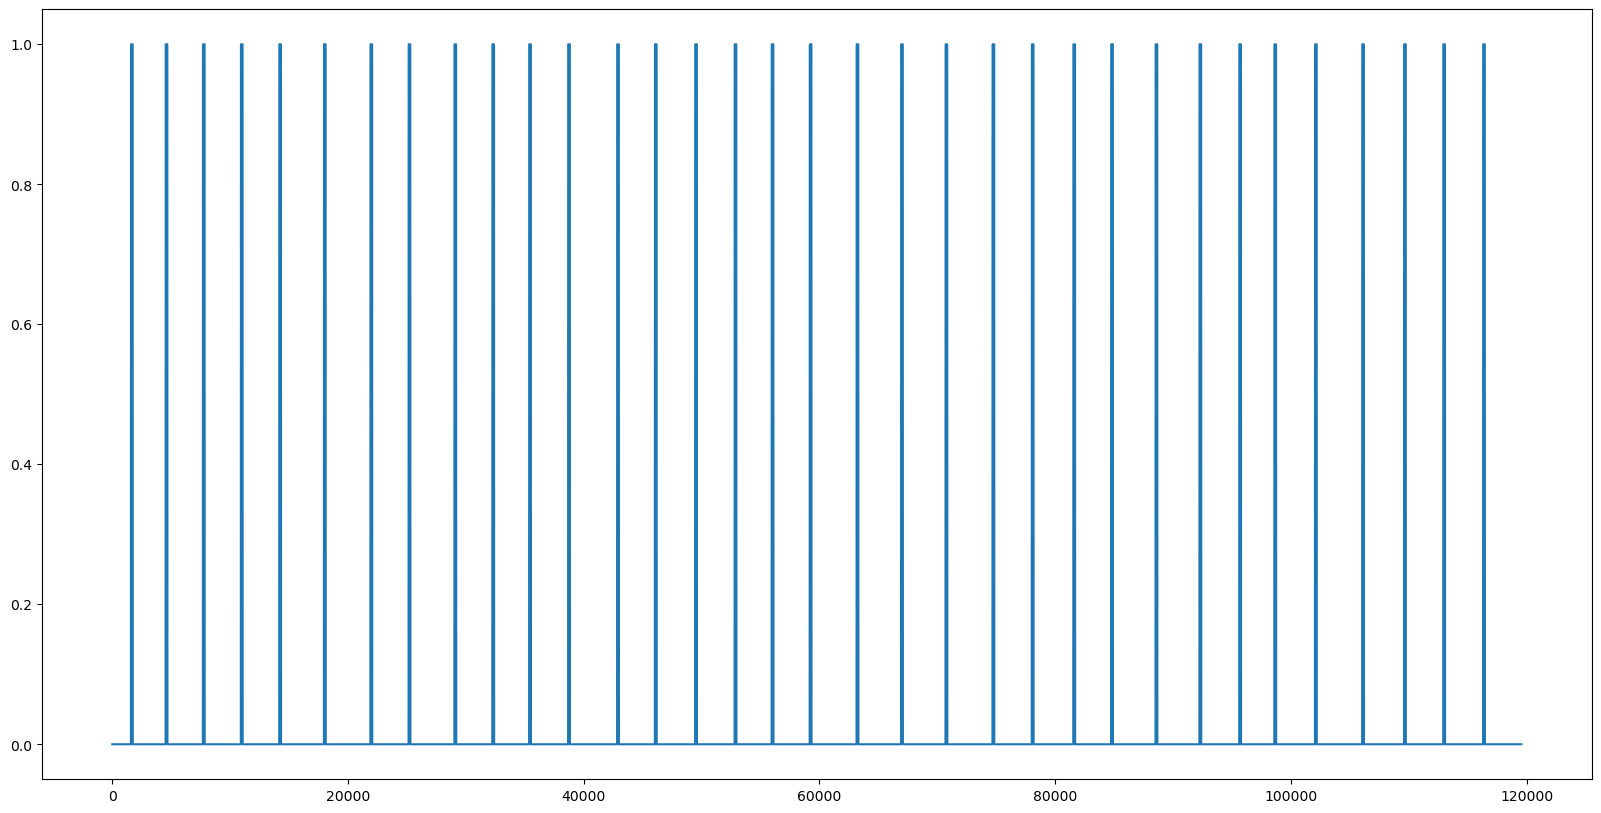

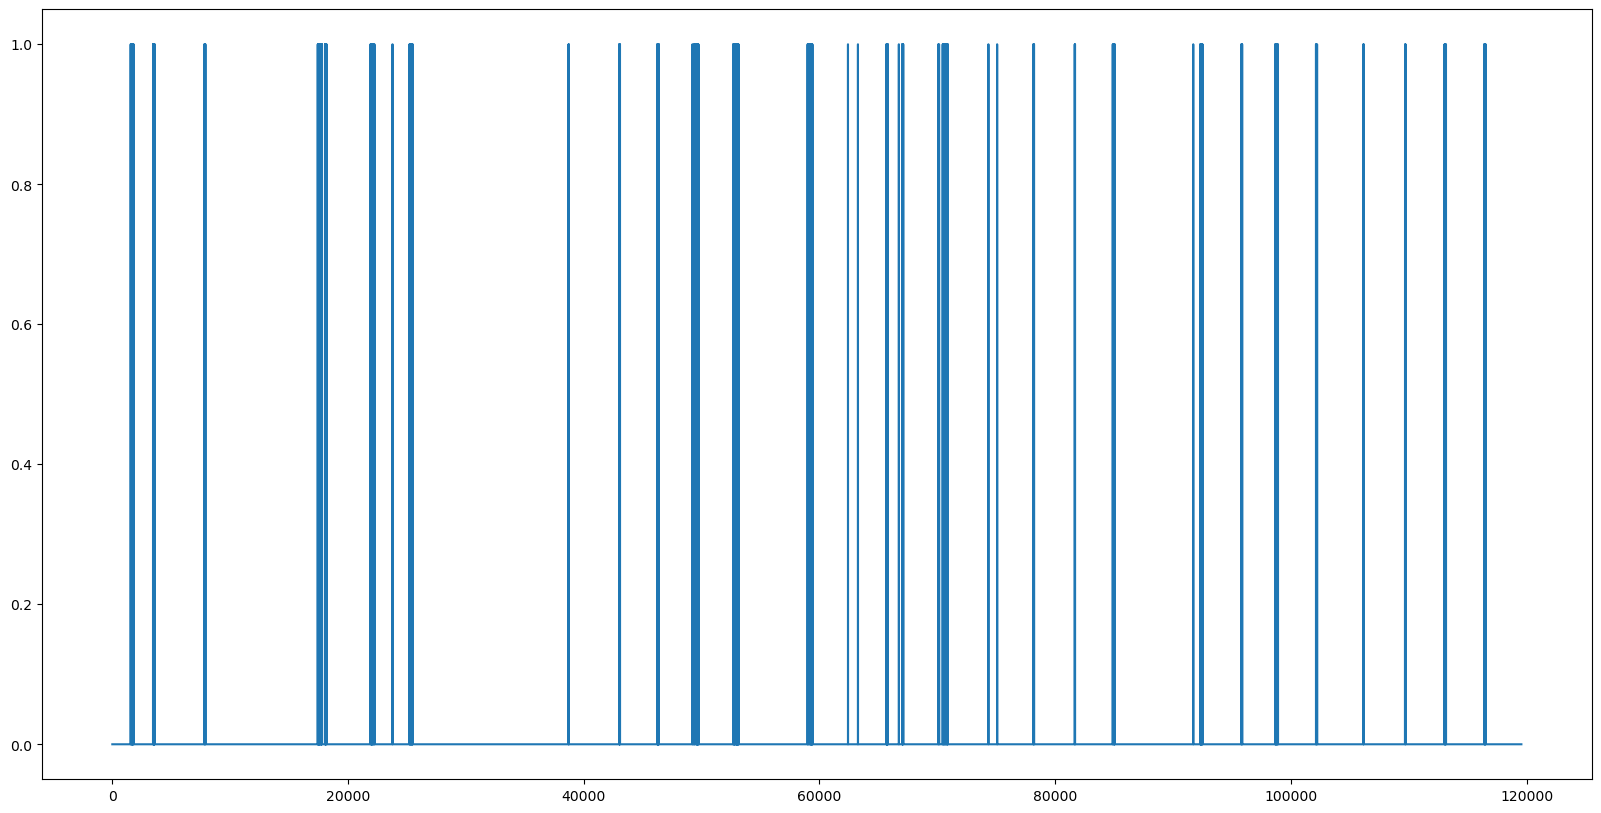

In [14]:
# plt.plot(np.round(y_pred[:,1]))

# print(y_pred.shape)
# print(y_test_data_series[0].shape)

np.sum(np.sum(y_pred[0][0:1000],0))
# plot y_test_data_series[0] with figure size of 20,10
plt.figure(figsize=(20,10))
plt.plot(y_test_data_series[0][:,0])
plt.figure(figsize=(20,10))
plt.plot(np.where(y_pred[0][:,0] > 0.5, 1, 0))
# plt.plot(y_pred[0][:,0])


# need to train some more on the 0s